In [1]:
# This is used to validate and calculate the spectrum/RGB color of specific metal 

import matplotlib
from tmm import coh_tmm, inc_tmm, position_resolved, find_in_structure_with_inf
import pandas as pd
import os
from numpy import pi
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.optimize import minimize
from tqdm import tqdm
import colour
from colour.difference import delta_E, delta_E_CIE2000
from colour import SDS_ILLUMINANTS, SpectralDistribution
from colour.colorimetry import MSDS_CMFS
import itertools
from multiprocessing import Pool
import pyswarms as ps

import colour
from colour.plotting import plot_chromaticity_diagram_CIE1931, ColourSwatch, plot_multi_colour_swatches, plot_sds_in_chromaticity_diagram_CIE1931
from colour.plotting.models import plot_RGB_colourspaces_in_chromaticity_diagram
from colour import MSDS_CMFS, SDS_ILLUMINANTS, SpectralDistribution
import warnings
warnings.filterwarnings('ignore')


illuminant = SDS_ILLUMINANTS['D65']
# cmfs = MSDS_CMFS['CIE 1931 2 Degree Standard Observer']
cmfs = MSDS_CMFS['CIE 1964 10 Degree Standard Observer']
# cmfs = MSDS_CMFS['CIE 2012 10 Degree Standard Observer']


mats = ['SiO2', 'Ti3O5']

lamda_low = 0.36
lamda_high = 0.8

wavelengths = np.arange(lamda_low, lamda_high+1e-3, 0.01)


def load_materials(all_mats = mats, wavelengths = wavelengths):
    '''
    Load material nk and return corresponding interpolators.

    Return:
        nk_dict: dict, key -- material name, value: n, k in the 
        self.wavelength range
    '''
    nk_dict = {}

    for mat in all_mats:
        nk = pd.read_csv(mat + '.csv')
        nk.dropna(inplace=True)

        wl = nk['wl'].to_numpy()
        index_n = nk['n'].to_numpy()
        index_k = nk['k'].to_numpy()

        n_fn = interp1d(
                wl, index_n,  bounds_error=False, fill_value='extrapolate', kind=3)
        k_fn = interp1d(
                wl, index_k,  bounds_error=False, fill_value='extrapolate', kind=1)
            
        nk_dict[mat] = n_fn(wavelengths) + 1j*k_fn(wavelengths)
    nk_dict['Air'] = np.ones_like(nk_dict['SiO2'])
    nk_dict['Resin'] = 1.33*np.ones_like(nk_dict['SiO2'])


    return nk_dict

nk_dict = load_materials()
targets = pd.read_csv('targets.csv')
target_0 = targets['0'].to_numpy()
target_30 = targets['30'].to_numpy()
target_45 = targets['45'].to_numpy()
target_60 = targets['60'].to_numpy()
TARGET_SPECTRUM = np.zeros([4, len(targets['nm'])])
TARGET_SPECTRUM[0, :] = target_0
TARGET_SPECTRUM[1, :] = target_30
TARGET_SPECTRUM[2, :] = target_45
TARGET_SPECTRUM[3, :] = target_60
TARGET_SPECTRUM = TARGET_SPECTRUM/100

TARGET_LAB = [[84.75,2.31,10.98],[83.46, -13.1, 7.24], [77.57, -32.5, -4.5], [69.17, -16.2, -20.8]]
TARGET_LAB = [[84.68, 0.24,   2.36], [ 83.83, -12.19 ,  -0.67], [ 79.00, -31.17, -10.68], [ 71.52, -21.93, -25.53]]

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120
mpl.rcParams['figure.figsize'] = (6, 4)
mpl.rcParams['legend.fontsize'] = 12
mpl.rcParams['axes.titlesize'] = 12
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['axes.labelsize'] = 12
mpl.rcParams['axes.titlepad'] = 12
mpl.rcParams.update({'font.size': 12})
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

(0, 100)

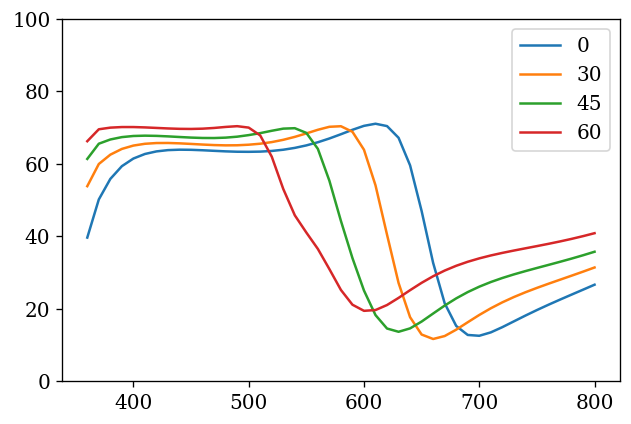

In [2]:
plt.plot(targets['nm'], targets['0'], label='0') 
plt.plot(targets['nm'], targets['30'], label='30')
plt.plot(targets['nm'], targets['45'], label='45')
plt.plot(targets['nm'], targets['60'], label='60')
plt.legend()
plt.ylim(0, 100)

In [35]:
def spectrum(materials, thickness, theta=0,pol = 's', wavelengths = wavelengths, nk_dict= nk_dict,  substrate = 'Resin'):
    '''
    Input:
        materials: list
        thickness: list
        mixing_ratio: list
        theta: degree, the incidence angle

    Return:
        s: array, spectrum
    '''
    #print(materials, thickness, mixing_ratio)
    thickness = [np.inf, 1000000] + thickness + [1000000, np.inf]
    
    degree = pi/180

    R, T, A, LAB, RGB = [], [], [], [], []
    for i, lambda_vac in enumerate(wavelengths * 1e3):

        nk_wave = [nk_dict[mat][i] for mat in materials]
        
        inc_list = ['i', 'i'] + ['c']*len(nk_wave) + ['i', 'i']
        n_list = [1, nk_dict[substrate][i]] + nk_wave + [nk_dict[substrate][i], 1]

        #print(n_list, thickness)
        # res = coh_tmm(pol, n_list, thickness, theta * degree, lambda_vac)
        res = inc_tmm(pol, n_list, thickness, inc_list, theta * degree, lambda_vac)

        R.append(res['R'])
        T.append(res['T'])

    R, T = np.array(R), np.array(T)
    A = 1 - R - T

    data = dict(zip((1e3 * wavelengths).astype('int'), R))
    sd = SpectralDistribution(data)
    XYZ = colour.sd_to_XYZ(sd, cmfs, illuminant)
    RLab = colour.XYZ_to_Lab(XYZ / 100)
    RRGB = colour.XYZ_to_sRGB(XYZ / 100)
    xyY = colour.XYZ_to_xyY(XYZ)

    All_result = {'R':R, 'T':T, 'A':A, 'RLAB':RLab, 'RRGB':RRGB, 'RxyY':xyY}
    return All_result


from scipy.optimize import minimize

def get_color(R, wavelengths = wavelengths):
    # return the xyY, RGB, LAB from reflection
    data = dict(zip((1e3 * wavelengths).astype('int'), R))
    sd = SpectralDistribution(data)

    XYZ = colour.sd_to_XYZ(sd, cmfs, illuminant)
    xyY = colour.XYZ_to_xyY(XYZ)
    Lab = colour.XYZ_to_Lab(XYZ / 100)
    RGB = colour.XYZ_to_sRGB(XYZ / 100)


    return Lab, RGB, xyY

In [33]:
all_mat_combs = [['SiO2', 'Ti3O5','SiO2', 'Ti3O5','SiO2', 'Ti3O5','SiO2'], 
                 [ 'Ti3O5','SiO2', 'Ti3O5','SiO2', 'Ti3O5','SiO2', 'Ti3O5'],
                 ['SiO2', 'Ti3O5','SiO2', 'Ti3O5','SiO2', 'Ti3O5','SiO2', 'Ti3O5'], 
                 [ 'Ti3O5','SiO2', 'Ti3O5','SiO2', 'Ti3O5','SiO2', 'Ti3O5', 'SiO2'],
                 ['SiO2', 'Ti3O5','SiO2', 'Ti3O5','SiO2', 'Ti3O5','SiO2', 'Ti3O5','SiO2'], 
                 [ 'Ti3O5','SiO2', 'Ti3O5','SiO2', 'Ti3O5','SiO2', 'Ti3O5','SiO2', 'Ti3O5']]

# run the scan and optmization, 
# Do not run!!!!!!!!!!!!!!!!!!!!!!

all_optim_thick  = []
all_optim_res = []
all_optim_spec = []
all_optim_lab = []
for mm in range(len(all_mat_combs)):

    materials = all_mat_combs[mm].copy()
    print('\nCurrent: ', mm, 'in ', len(all_mat_combs), ' layers: ', materials)

    min_thick = 10
    max_thick = 500
    diff_thick = 5

    def cal_spectrum(x):
        # optimize the spectrum from 4 reflection directions
        LABs = np.zeros([4, 3])
        spectrums = []
        angles = [0, 30, 45, 60]
        # angles = [0]
        for i in range(len(angles)):
            All_result_s = spectrum(materials, list(x), theta = angles[i], pol = 's')
            All_result_p = spectrum(materials, list(x), theta = angles[i], pol = 'p')
            spec = (All_result_s['R'] + All_result_p['R'])/2
            spectrums.append(spec)
            Lab, rgb, xyy = get_color(spec)
            LABs[i, :] = Lab
        
        spectrums = np.array(spectrums)
        
        return spectrums, LABs
    
    def objective_func_1(x, temp = [0]):
        
        spectrums, labs = cal_spectrum(x)
        
        # return np.mean(np.abs(spectrums - TARGET_SPECTRUM))
        
        return sum([delta_E(labs[i], TARGET_LAB[i]) for i in range(1)])
    
    def objective_func_4(x, temp = [0]):
        
        spectrums, labs = cal_spectrum(x)
        
        # return np.mean(np.abs(spectrums - TARGET_SPECTRUM))
        
        return sum([delta_E(labs[i], TARGET_LAB[i]) for i in range(4)])
    

    NUM = 50

    pool = Pool(NUM)
    
    def cal_object_1(x, tempp=[0]):
        diff = pool.starmap(objective_func_1, itertools.product(x, tempp))
        return diff
    
    def cal_object_4(x, tempp=[0]):
        diff = pool.starmap(objective_func_4, itertools.product(x, tempp))
        return diff
    

    def finetune_PSO_1(materials):

        options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}
        bounds = np.repeat([[min_thick],[max_thick]], len(materials), axis=1)
        # init_pos = np.repeat(np.reshape(aa, [1, -1]), NUM, axis=0)
        init_pos = np.random.uniform(min_thick, max_thick, [NUM, len(materials)])

        for i in range(len(materials)):
            init_pos[:, i] = np.clip(init_pos[:, i], a_min=bounds[0,i], a_max=bounds[1,i])

        optimizer = ps.single.GlobalBestPSO(n_particles=NUM, dimensions=len(materials), options=options, bounds=bounds, init_pos=init_pos, ftol=1e-13, ftol_iter=20)
        cost, pos = optimizer.optimize(cal_object_1, 50, verbose=True)

        return pos, cost
    
    def finetune_PSO_4(materials, initials):

        options = {'c1': 0.5, 'c2': 0.3, 'w':0.7}
        bounds = np.repeat([[min_thick],[max_thick]], len(materials), axis=1)
        init_pos = np.repeat(np.reshape(np.array(initials), [1, -1]), NUM, axis=0)

        for i in range(len(materials)):
            init_pos[:, i] = np.clip(init_pos[:, i], a_min=bounds[0,i], a_max=bounds[1,i])

        optimizer = ps.single.GlobalBestPSO(n_particles=NUM, dimensions=len(materials), options=options, bounds=bounds, init_pos=init_pos, ftol=1e-13, ftol_iter=20)
        cost, pos = optimizer.optimize(cal_object_4, 500, verbose=True)

        return pos, cost

    thickness, res = finetune_PSO_1(materials)
    thickness, res = finetune_PSO_4(materials, thickness)

    print('materials = ', materials, '\nthickness = ', thickness, ',', res )
    thickness = [int(thicks) for thicks in thickness]
    all_optim_thick.append(materials + thickness)
    all_optim_res.append(res)
    specs, labs = cal_spectrum(thickness)
    all_optim_spec.append(specs)
    all_optim_lab.append(labs)
    print('Delta_E = ', [delta_E(labs[i], TARGET_LAB[i]) for i in range(4)])
    all_results = {'all_mat_combs':all_mat_combs, 'all_optim_thick':all_optim_thick, 'all_optim_res':all_optim_res, 'all_optim_spec':all_optim_spec, 'all_optim_lab':all_optim_lab}
    np.save('./all_results/all_res_optimize_LAB_1_to_4_c1_c2_w=0.5_0.3_0.7_random_1.npy', all_results)





Current:  0 in  6  layers:  ['SiO2', 'Ti3O5', 'SiO2', 'Ti3O5', 'SiO2', 'Ti3O5', 'SiO2']


2023-02-28 21:45:42,769 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:  52%|█████▏    |26/50, best_cost=7.53
2023-02-28 21:46:02,918 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7.531369712295335, best pos: [ 135.30822095   48.37431226   65.93951476   71.26402781  305.09667301
  445.69955674  289.63268739]
2023-02-28 21:46:02,922 - pyswarms.single.global_best - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.7}
pyswarms.single.global_best:  59%|█████▉    |297/500, best_cost=30 
2023-02-28 21:49:30,215 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 29.958145261302928, best pos: [ 134.63290161   48.03143291   66.76758984   68.6705577   306.35291752
  446.15235975  289.86020497]


materials =  ['SiO2', 'Ti3O5', 'SiO2', 'Ti3O5', 'SiO2', 'Ti3O5', 'SiO2'] 
thickness =  [ 134.63290161   48.03143291   66.76758984   68.6705577   306.35291752
  446.15235975  289.86020497] , 29.9581452613
Delta_E =  [8.7630075190363641, 10.401829040212677, 6.7411344765290808, 4.4952782765243064]

Current:  1 in  6  layers:  ['Ti3O5', 'SiO2', 'Ti3O5', 'SiO2', 'Ti3O5', 'SiO2', 'Ti3O5']


2023-02-28 21:49:31,055 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|50/50, best_cost=5.61
2023-02-28 21:50:07,959 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 5.612021936795173, best pos: [ 441.07491977   85.29879903  311.71872132   81.74213895  370.85193798
  287.39250545  308.32535441]
2023-02-28 21:50:07,963 - pyswarms.single.global_best - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.7}
pyswarms.single.global_best:  57%|█████▋    |287/500, best_cost=37 
2023-02-28 21:53:39,460 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 37.01191982034339, best pos: [ 442.88976926   87.2957023   312.43456618   83.48479324  374.15132768
  287.21971299  311.12267973]


materials =  ['Ti3O5', 'SiO2', 'Ti3O5', 'SiO2', 'Ti3O5', 'SiO2', 'Ti3O5'] 
thickness =  [ 442.88976926   87.2957023   312.43456618   83.48479324  374.15132768
  287.21971299  311.12267973] , 37.0119198203
Delta_E =  [6.0991990355050065, 6.0137315212158091, 8.5469259071431782, 16.467798462433002]

Current:  2 in  6  layers:  ['SiO2', 'Ti3O5', 'SiO2', 'Ti3O5', 'SiO2', 'Ti3O5', 'SiO2', 'Ti3O5']


2023-02-28 21:53:40,406 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|50/50, best_cost=5.26
2023-02-28 21:54:18,093 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 5.257240488262865, best pos: [ 168.64173198  205.12953061  251.03575047   61.38612497  359.58524157
  311.90718943   85.4373917   173.0064057 ]
2023-02-28 21:54:18,097 - pyswarms.single.global_best - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.7}
pyswarms.single.global_best:  62%|██████▏   |312/500, best_cost=42.4
2023-02-28 21:58:06,590 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 42.416163974596586, best pos: [ 169.2078763   207.27720449  252.26340285   61.54087516  361.11055643
  312.56646322   84.21240079  170.32291082]


materials =  ['SiO2', 'Ti3O5', 'SiO2', 'Ti3O5', 'SiO2', 'Ti3O5', 'SiO2', 'Ti3O5'] 
thickness =  [ 169.2078763   207.27720449  252.26340285   61.54087516  361.11055643
  312.56646322   84.21240079  170.32291082] , 42.4161639746
Delta_E =  [5.616192815419554, 8.6504119024479333, 12.211935772996252, 16.046279441634837]

Current:  3 in  6  layers:  ['Ti3O5', 'SiO2', 'Ti3O5', 'SiO2', 'Ti3O5', 'SiO2', 'Ti3O5', 'SiO2']


2023-02-28 21:58:07,618 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|50/50, best_cost=3.13
2023-02-28 21:58:45,591 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 3.128022015001311, best pos: [ 198.97394282  124.20761233   41.49339461   93.74624017   64.88431541
  204.88378886  392.3199094    68.33734919]
2023-02-28 21:58:45,598 - pyswarms.single.global_best - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.7}
pyswarms.single.global_best:  67%|██████▋   |333/500, best_cost=44.5
2023-02-28 22:02:46,404 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 44.52572861968616, best pos: [ 196.50414304  121.98158467   39.99536349   93.00404924   64.63111102
  205.51454209  391.7937456    67.71169771]


materials =  ['Ti3O5', 'SiO2', 'Ti3O5', 'SiO2', 'Ti3O5', 'SiO2', 'Ti3O5', 'SiO2'] 
thickness =  [ 196.50414304  121.98158467   39.99536349   93.00404924   64.63111102
  205.51454209  391.7937456    67.71169771] , 44.5257286197
Delta_E =  [3.9212296800064492, 7.2582272235755774, 13.08164810936162, 17.942637567603764]

Current:  4 in  6  layers:  ['SiO2', 'Ti3O5', 'SiO2', 'Ti3O5', 'SiO2', 'Ti3O5', 'SiO2', 'Ti3O5', 'SiO2']


2023-02-28 22:02:47,467 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|50/50, best_cost=5.63
2023-02-28 22:03:26,170 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 5.631217928158591, best pos: [ 298.96971859  404.69898192  234.6777868    56.29323238   98.15092227
  209.14520966  284.44062304  295.75470548   42.06392232]
2023-02-28 22:03:26,174 - pyswarms.single.global_best - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.7}
pyswarms.single.global_best:  64%|██████▎   |318/500, best_cost=34.4
2023-02-28 22:07:25,577 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 34.37893187172984, best pos: [ 301.04055243  405.1418494   238.76719369   58.43896974   98.92950975
  211.80855994  285.50857869  295.91014306   42.30081585]


materials =  ['SiO2', 'Ti3O5', 'SiO2', 'Ti3O5', 'SiO2', 'Ti3O5', 'SiO2', 'Ti3O5', 'SiO2'] 
thickness =  [ 301.04055243  405.1418494   238.76719369   58.43896974   98.92950975
  211.80855994  285.50857869  295.91014306   42.30081585] , 34.3789318717
Delta_E =  [5.9209987536710136, 5.050257504143346, 7.9969940863596891, 15.878475070402903]

Current:  5 in  6  layers:  ['Ti3O5', 'SiO2', 'Ti3O5', 'SiO2', 'Ti3O5', 'SiO2', 'Ti3O5', 'SiO2', 'Ti3O5']


2023-02-28 22:07:26,707 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:  52%|█████▏    |26/50, best_cost=2.39
2023-02-28 22:07:48,507 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2.38511419664, best pos: [ 305.55708469  325.32406735  238.8927536   280.07625559   87.60938493
  291.22754355   41.98864177   80.34335079   43.74734156]
2023-02-28 22:07:48,510 - pyswarms.single.global_best - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.7}
pyswarms.single.global_best:  65%|██████▌   |326/500, best_cost=8.84
2023-02-28 22:11:59,747 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 8.835205321486304, best pos: [ 306.70466468  324.61202669  241.26491576  280.67095283   90.14654896
  290.87840344   43.8098572    81.90007372   44.84412138]


materials =  ['Ti3O5', 'SiO2', 'Ti3O5', 'SiO2', 'Ti3O5', 'SiO2', 'Ti3O5', 'SiO2', 'Ti3O5'] 
thickness =  [ 306.70466468  324.61202669  241.26491576  280.67095283   90.14654896
  290.87840344   43.8098572    81.90007372   44.84412138] , 8.83520532149
Delta_E =  [2.0995553002565761, 2.4009695245434663, 3.1535174710458267, 2.7786225866973959]


In [28]:
# load saved files

all_results = np.load('./all_results/all_res_optimize_LAB_1_to_4_c1_c2_w=0.5_0.3_0.7_random_1.npy', allow_pickle=True).tolist()
all_mat_combs = all_results['all_mat_combs']
all_optim_thick = all_results['all_optim_thick']
all_optim_res = all_results['all_optim_res']
all_optim_spec = all_results['all_optim_spec']
all_optim_lab = all_results['all_optim_lab']


Target LAB:
0 degree [84.68, 0.24, 2.36] 
30 degree [83.83, -12.19, -0.67] 
45 degree [79.0, -31.17, -10.68] 
60 degree [71.52, -21.93, -25.53]
Designed LAB:
0 degree [ 82.10032921  -0.2440432    1.31836913] 
30 degree [ 80.90137815 -13.92537577  -0.84876706] 
45 degree [ 76.5766906  -27.6111723   -6.81499665] 
60 degree [ 71.18102599 -17.14507065 -21.37993347]


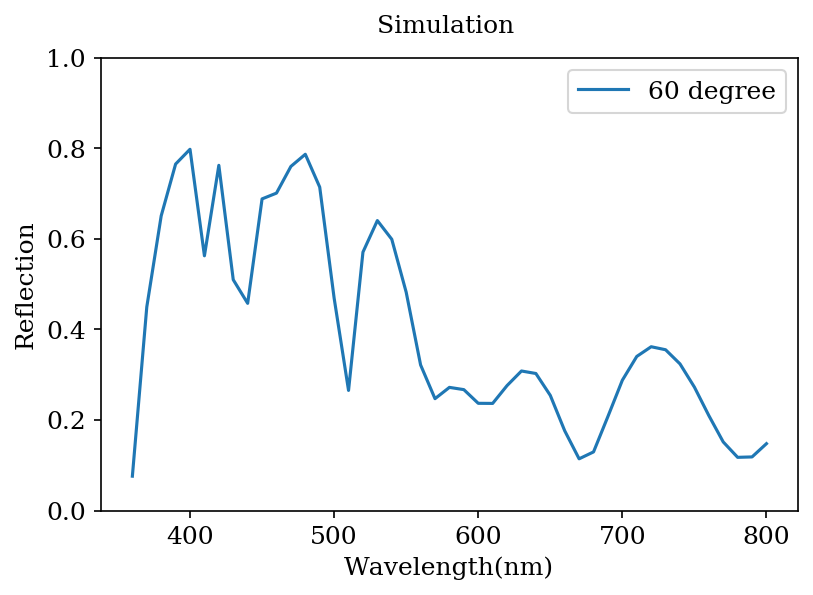

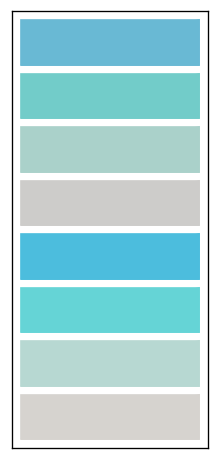

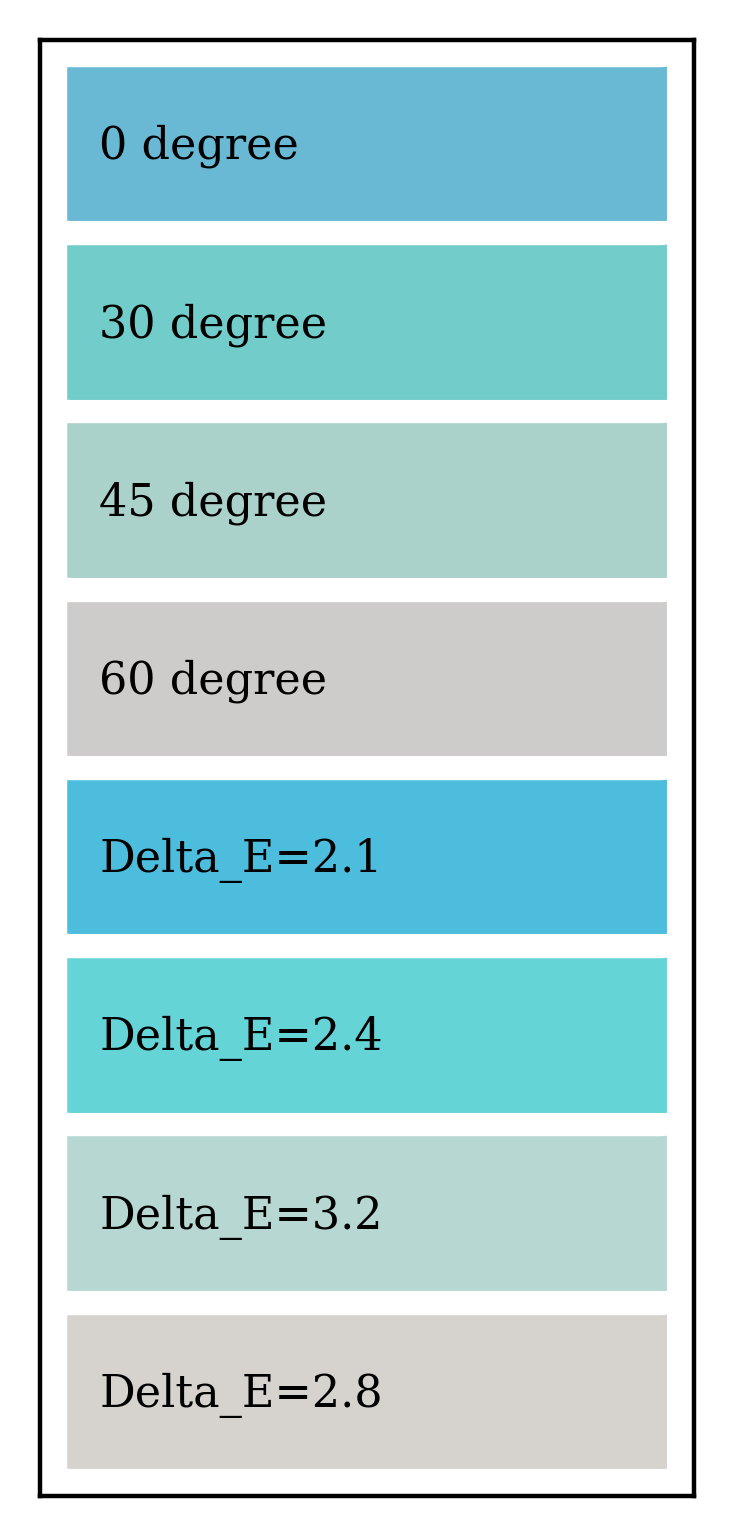

In [45]:
# visualization of the spectrum and color difference

temp = 5

final_rgb = colour.XYZ_to_sRGB(colour.Lab_to_XYZ(np.concatenate([TARGET_LAB, all_optim_lab[temp]], axis=0)))

# plt.plot(targets['nm'], TARGET_SPECTRUM[0, :], color =final_rgb[0],  label='0') 
# plt.plot(targets['nm'], TARGET_SPECTRUM[1, :], color =final_rgb[1],label='30')
# plt.plot(targets['nm'], TARGET_SPECTRUM[2, :], color =final_rgb[2],label='45')
# plt.plot(targets['nm'], TARGET_SPECTRUM[3, :], color =final_rgb[3],label='60')
fig = plt.figure(dpi=150, figsize=[6, 4])
fig.patch.set_facecolor('white')

plt.plot(targets['nm'], all_optim_spec[temp][0, :], '--', label='0 degree') 
# plt.plot(targets['nm'], all_optim_spec[temp][1, :], '--', label='30 degree')
# plt.plot(targets['nm'], all_optim_spec[temp][2, :], '--', label='45 degree')
# plt.plot(targets['nm'], all_optim_spec[temp][3, :], '--', label='60 degree')

plt.legend()
plt.ylim(0, 1)
plt.ylabel('Reflection')
plt.xlabel('Wavelength(nm)')
plt.title('Simulation ')

print('Target LAB:')
print('0 degree', TARGET_LAB[0], '\n30 degree', TARGET_LAB[1], '\n45 degree', TARGET_LAB[2], '\n60 degree', TARGET_LAB[3])
print('Designed LAB:')
print('0 degree', all_optim_lab[temp][0], '\n30 degree', all_optim_lab[temp][1], '\n45 degree', all_optim_lab[temp][2], '\n60 degree', all_optim_lab[temp][3])

angles = [0, 30, 45, 60]
fig, ax = colour.plotting.plot_multi_colour_swatches(final_rgb, spacing=0.2, columns=1,height = 1, width = 4)
fig.set_dpi(400)
for i in range(4):
    ax.text( 0.2, 0.4 + 1.2*3 - 1.2*i, 'Delta_E='+str(round(delta_E(all_optim_lab[temp][i], TARGET_LAB[i]), 1)), fontsize = 8, color='black')
    ax.text( 0.2, 0.4 + 1.2*7 - 1.2*(i), str(angles[i]) + ' degree', fontsize = 8, color='black')
    
fig

In [ ]:
# save files 

import csv  

header = ['wavelength', '0 degree', '30 degree', '45 degree', '60 degree']
data = np.concatenate([np.reshape(np.array([targets['nm']]), [-1, 1]), np.transpose(all_optim_spec[5])], axis=1)

with open('simulation.csv', 'w', encoding='UTF8') as f:
    writer = csv.writer(f)

    # write the header
    writer.writerow(header)

    # write the data
    for i in range(len(data)):
        writer.writerow(data[i])